In [1]:
import geopandas as gpd
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

from shapely.geometry import box, Polygon, Point
from shapely.ops import orient
import shapely.wkt
import pyproj
from pyproj import Geod

tqdm.pandas()

In [2]:
# Paths
OAK_FP = '/oak/stanford/groups/deho/building_compliance/'
CF_FP = os.path.join(OAK_FP, 'CloudFactory')
INPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'inputs')
OUTPUT_FP = os.path.join(OAK_FP, 'outputs', 'Population-Estimates', 'outputs')

In [5]:
sj_parcels_cbgs.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159930 entries, 0 to 159929
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   APN       159930 non-null  object  
 1   GEOID     159930 non-null  object  
 2   geometry  159930 non-null  geometry
dtypes: geometry(1), object(2)
memory usage: 3.7+ MB


In [4]:
sj_parcels_cbgs.loc[sj_parcels_cbgs['APN'] == '46731021']

,APN,GEOID,geometry
80231,46731021,060855014022,"POLYGON ((-121.86972 37.34456, -121.86961 37.3..."


In [3]:
# Input data
# * Universe of SJ res parcels assigned to each CBG
sj_parcels_cbgs = gpd.read_file(os.path.join(OUTPUT_FP, 'sj-parcels-res-cbgs'))

# * Income-stratified CBGs (from Pop-Estimates-Strata.ipynb)
cbg_income_2016_SJ = gpd.read_file(os.path.join(OUTPUT_FP, 'Strata', 'cbg-income-strata'))

In [4]:
# Parcel bins
parcel_conf_df = pd.read_csv(
    os.path.join(OUTPUT_FP, 'Confidences_construction', 'parcel-confidence.csv'))
parcel_conf_df['Bin'] = parcel_conf_df.apply(
    lambda row: '{}-{}'.format(row['strata_inc'], row['confidence']), axis=1)

In [5]:
# Neyman inputs
Neyman_alloc = pd.read_csv(
    os.path.join(
        OUTPUT_FP, 'Outcomes', 'B1-100', 'PA', 'PA-neyman_alloc-CF-min11-GT1.csv'))

In [6]:
# Batch 3 - Part 1
sample = pd.read_csv(os.path.join(
    OAK_FP, 'outputs', 'Population-Estimates','CloudFactory/Iteration3/sampled_APNs.csv'), 
                     dtype={'APN': str, 'GEOID': str})
sample['GEOID'] = sample['GEOID'].apply(lambda g: '0' + g)
sample = sample.loc[:5000]

df_processed = pd.read_csv(
    os.path.join(CF_FP, 'results', 'Batch3_part1', 'processed_buildings.csv'), 
    dtype={'apn': str})

# Filter by size
wgs84 = pyproj.CRS('EPSG:4326')
utm = pyproj.CRS('EPSG:26910')
project = pyproj.Transformer.from_crs(wgs84, utm, always_xy=True).transform
df_processed['2016_a'] = df_processed['2016'].apply(lambda x: shapely.ops.transform(project, shapely.wkt.loads(x)).area if not pd.isna(x) else x)
df_processed['2020_a'] = df_processed['2020'].apply(lambda x: shapely.ops.transform(project, shapely.wkt.loads(x)).area if not pd.isna(x) else x)

df_processed = df_processed[(df_processed['2016_a'] >= 11.15) | (df_processed['2020_a'] >= 11.15)]

In [7]:
# Aggregate and define construction events
df_processed['construction_event'] = 1 - df_processed['exact_match']
df_processed = df_processed.groupby('apn')['construction_event'].sum().reset_index()

In [8]:
# Get construction events and median income for each parcel
CF_parcels = sample.copy()
CF_parcels = CF_parcels.merge(df_processed, how='left', left_on='APN', right_on='apn', validate='one_to_one')

# Fill with zeros (no construction events in parcels that don't appear in df_processed)
CF_parcels['construction_event'] = CF_parcels['construction_event'].fillna(0).astype(int)

CF_parcels = CF_parcels.merge(
    cbg_income_2016_SJ[['GEOID', 'median_inc']], how='left', on='GEOID', validate='many_to_one')

In [9]:
# Compute proportional weights
Prop_alloc = sj_parcels_cbgs.copy()
Prop_alloc = Prop_alloc.merge(
    parcel_conf_df[['APN', 'Bin']], how='left', validate='one_to_one')
Prop_alloc = Prop_alloc.groupby('Bin')['APN'].count().reset_index()
Prop_alloc.rename(columns={'APN': 'N_j'}, inplace=True)
Prop_alloc['weight'] = Prop_alloc['N_j'] / Prop_alloc['N_j'].sum()

In [10]:
# Compute sampling ratio (weights for WLS)
ratio = Neyman_alloc.copy()
ratio.rename(columns={'weight': 'Neyman_weight'}, inplace=True)
ratio = ratio.merge(Prop_alloc[['Bin', 'weight']], validate='one_to_one')
ratio.rename(columns={'weight': 'Prop_weight'}, inplace=True)
ratio['sampling_ratio'] = ratio['Neyman_weight'] / ratio['Prop_weight']
ratio['w'] = 1 / ratio['sampling_ratio']

CF_parcels = CF_parcels.merge(ratio[['Bin', 'w']], validate='many_to_one')

# Sample a Stratified Allocation of fixed size

In [11]:
def generate_sample(N, df, alloc_df, replace=True):
    alloc_df['n_j'] = round(alloc_df['weight'] * N, 0).astype(int)
    size_dict = pd.Series(alloc_df['n_j'].values, index=alloc_df['Bin']).to_dict()
    sample_df = df.groupby('Bin', group_keys=False).apply(
        lambda df: df.sample(n=size_dict[df.name], replace=replace).reset_index(drop=True))
    if sample_df.index.nlevels > 1:
        sample_df = sample_df.droplevel(0, axis=0)
    return sample_df

In [38]:
n = 800
prop_sample = generate_sample(N=n, df=CF_parcels, alloc_df=Prop_alloc, replace=False)


# Compute estimate on a sample

In [12]:
def compute_estimate(df, sample_type):
    if sample_type == 'Neyman':
        reg = LinearRegression().fit(
            df['median_inc'].to_numpy().reshape(-1, 1), df['construction_event'], df['w'])
    else:
        reg = LinearRegression().fit(
            df['median_inc'].to_numpy().reshape(-1, 1), df['construction_event'])
    
    # Estimate
    return reg.coef_.item()

In [13]:
#sample_df = generate_sample(N=5000, df=CF_parcels, alloc_df=Prop_alloc)

# Multiple n

## M <= N

In [14]:
# Generate data
K = 5000
estimate_df = pd.DataFrame()
for n in tqdm(range(1000, 5000, 500)):
    for k in range(K):
        # Generate prop sample
        prop_sample = generate_sample(N=n, df=CF_parcels, alloc_df=Prop_alloc, replace=True)

        # Generate Neyman sample
        ney_sample = generate_sample(N=n, df=CF_parcels, alloc_df=Neyman_alloc, replace=True)

        # Estimates
        estimate_dict = {
            'n': [n], 'k': [k],
            'Beta (Proportional Alloc)': [compute_estimate(df=prop_sample, sample_type='prop')], 
            'Beta (Neyman Alloc)': [compute_estimate(df=ney_sample, sample_type='Neyman')]}
        estimate_df = pd.concat([estimate_df, pd.DataFrame.from_dict(estimate_dict)])

100%|██████████| 8/8 [1:59:42<00:00, 897.78s/it]


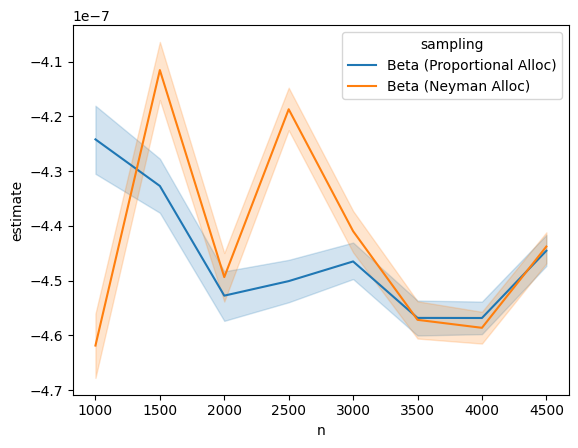

In [15]:
# Plot
estimate_df_long = estimate_df.melt(id_vars=['n', 'k'], var_name='sampling', value_name='estimate')
sns.lineplot(estimate_df_long, x='n', y='estimate', hue='sampling')
plt.show()

In [17]:
estimate_df_long.to_csv('SRSvNeyman/resampledSRS.csv', index=False)

In [26]:
estimate_df_long = pd.read_csv('SRSvNeyman/resampledSRS.csv')

In [27]:
estimate_df_long.head()

,n,k,sampling,estimate
0,1000,0,Beta (Proportional Alloc),-5.989911e-07
1,1000,1,Beta (Proportional Alloc),-6.615740e-07
2,1000,2,Beta (Proportional Alloc),-2.306407e-07
3,1000,3,Beta (Proportional Alloc),-2.551301e-07
4,1000,4,Beta (Proportional Alloc),-5.569014e-07


## Limiting the SRS

In [74]:
# Without replacement to fill in Neyman samples
max_n = 1667
N = len(CF_parcels)

In [65]:
# Note: per https://projecteuclid.org/journals/annals-of-statistics/volume-22/issue-4/Large-Sample-Confidence-Regions-Based-on-Subsamples-under-Minimal-Assumptions/10.1214/aos/1176325770.full
# we can generate samples of size M < N (in our clase, M=N_max)
# and compute confidence intervals on our estimate by appropriately scaling the CIs


# Generate data
#K = 100 # Bootstrap samples
R = 1000 # Slices of data
estimate_df_fixed = pd.DataFrame()
for n in tqdm(range(800, 1667, 200)): # 500
    for r in range(R): # 100
        # Fixed data to bootstrap -- there is no sampling with replacement here
        # * Generate prop sample
        prop_sample = generate_sample(N=n, df=CF_parcels, alloc_df=Prop_alloc, replace=False)

        # * Generate Neyman sample
        ney_sample = generate_sample(N=n, df=CF_parcels, alloc_df=Neyman_alloc, replace=False)

        #for k in range(K):
        #    # Bootstrap the fixed samples
        #    # * Generate prop sample
        #    prop_sample = generate_sample(N=n, df=prop_sample, alloc_df=Prop_alloc, replace=True)

        #    # * Generate Neyman sample
        #    ney_sample = generate_sample(N=n, df=ney_sample, alloc_df=Neyman_alloc, replace=True)

        # Estimates
        estimate_dict = {
            'n': [n], #'k': [k],
            'r': [r],
            'Beta (Proportional Alloc)': [compute_estimate(df=prop_sample, sample_type='prop')], 
            'Beta (Neyman Alloc)': [compute_estimate(df=ney_sample, sample_type='Neyman')]}
        estimate_df_fixed = pd.concat([estimate_df_fixed, pd.DataFrame.from_dict(estimate_dict)])

100%|██████████| 5/5 [12:46<00:00, 153.40s/it]


In [25]:
adj_estimate

,n,Allocation,std,mean,median,ub,lb
0,800,Beta (Neyman Alloc),9.507624e-08,-4.966455e-07,-4.935697e-07,-3.102960e-07,-6.829949e-07
1,800,Beta (Proportional Alloc),8.820945e-08,-4.725729e-07,-4.693816e-07,-2.996824e-07,-6.454634e-07
2,1000,Beta (Neyman Alloc),9.261937e-08,-4.640366e-07,-4.736500e-07,-2.825027e-07,-6.455706e-07
3,1000,Beta (Proportional Alloc),8.928278e-08,-4.321099e-07,-4.360846e-07,-2.571157e-07,-6.071042e-07
4,1200,Beta (Neyman Alloc),8.895552e-08,-5.065061e-07,-5.036665e-07,-3.321533e-07,-6.808589e-07
5,1200,Beta (Proportional Alloc),8.588469e-08,-4.463108e-07,-4.483091e-07,-2.779768e-07,-6.146448e-07
6,1400,Beta (Neyman Alloc),9.019959e-08,-4.138058e-07,-4.166926e-07,-2.370146e-07,-5.905970e-07
7,1400,Beta (Proportional Alloc),8.151482e-08,-4.408241e-07,-4.434189e-07,-2.810550e-07,-6.005931e-07
8,1600,Beta (Neyman Alloc),8.929099e-08,-4.400151e-07,-4.381710e-07,-2.650048e-07,-6.150254e-07
9,1600,Beta (Proportional Alloc),7.898224e-08,-4.544636e-07,-4.544587e-07,-2.996584e-07,-6.092688e-07


In [81]:
adj_estimate = estimate_df_fixed.melt(
    id_vars=['n', 'r'], var_name='Allocation', value_name='Beta')

In [83]:
adj_estimate = adj_estimate.groupby(['n', 'Allocation'])['Beta'].agg(['std', 'mean', 'median']).reset_index()

In [85]:
# Adjust the SE
adj_estimate['std'] = adj_estimate['std'] * np.sqrt(adj_estimate['n']/N)

In [18]:
# Generate CIs
adj_estimate['ub'] = adj_estimate['mean'] + adj_estimate['std'] * 1.96
adj_estimate['lb'] = adj_estimate['mean'] - adj_estimate['std'] * 1.96

In [13]:
adj_estimate = pd.read_csv('SRSvNeyman/SRS.csv')

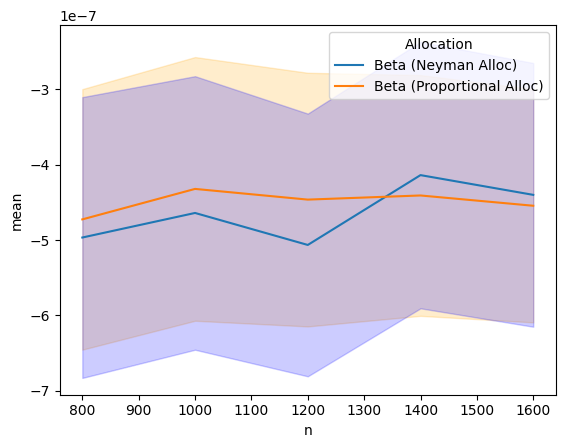

In [24]:
prop = adj_estimate.loc[adj_estimate['Allocation'] == 'Beta (Proportional Alloc)'].copy()
ney = adj_estimate.loc[adj_estimate['Allocation'] == 'Beta (Neyman Alloc)'].copy()

ax = sns.lineplot(data=adj_estimate, x='n', y="mean", errorbar=None, hue='Allocation')
ax.fill_between(
    prop['n'], prop['lb'], prop['ub'], alpha=0.2, color='orange')
ax.fill_between(
    ney['n'], ney['lb'], ney['ub'], alpha=0.2, color='blue')

#sns.lineplot(adj_estimate, x='n', y='estimate', hue='sampling')
plt.show()

In [68]:
# Compute point estimate and CIs
adj_estimate = estimate_df_fixed.groupby('n')[
    ['Beta (Proportional Alloc)', 'Beta (Neyman Alloc)']].agg(['std', 'mean', 'median']).reset_index()

In [78]:
#
adj_estimate.head()

,n-,Beta (Proportional Alloc)-std,Beta (Proportional Alloc)-mean,Beta (Proportional Alloc)-median,Beta (Neyman Alloc)-std,Beta (Neyman Alloc)-mean,Beta (Neyman Alloc)-median
0,800,8.820945e-08,-4.725729e-07,-4.693816e-07,9.507624e-08,-4.966455e-07,-4.935697e-07
1,1000,8.928278e-08,-4.321099e-07,-4.360846e-07,9.261937e-08,-4.640366e-07,-4.736500e-07
2,1200,8.588469e-08,-4.463108e-07,-4.483091e-07,8.895552e-08,-5.065061e-07,-5.036665e-07
3,1400,8.151482e-08,-4.408241e-07,-4.434189e-07,9.019959e-08,-4.138058e-07,-4.166926e-07
4,1600,7.898224e-08,-4.544636e-07,-4.544587e-07,8.929099e-08,-4.400151e-07,-4.381710e-07


In [72]:
adj_estimate.columns = [
    '{}-{}'.format(col[0], col[1]) if len(col) > 1 else col[0] for col in adj_estimate.columns ]

In [76]:
# Adjust the SE
adj_estimate['Beta (Proportional Alloc)-std'] = adj_estimate[
    'Beta (Proportional Alloc)-std'] * np.sqrt(adj_estimate['n-']/N)

In [77]:
adj_estimate['Beta (Neyman Alloc)-std'] = adj_estimate[
    'Beta (Neyman Alloc)-std'] * np.sqrt(adj_estimate['n-']/N)

In [ ]:
# Plot
estimate_df_long = adj_estimate.melt(
    id_vars=['n'], var_name='sampling', value_name='estimate')
sns.lineplot(estimate_df_long, x='n', y='estimate', hue='sampling')
plt.show()

In [86]:
adj_estimate.to_csv('SRSvNeyman/SRS.csv', index=False)